# SLAYER with Delay Learning using SHD-Norm Dataset

In [9]:
import pickle
import random
import numpy as np
from scipy import io
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as tnnf
from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

In [10]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../src")
import slayerSNN as snn

Load the SHD dataset (.mat)

X shape: (5460, 224, 100) Y shape: (5460,)

--- getting a batch from generator ---
x_batch: (4, 224, 100) y_batch: [ 6  4  3 14]


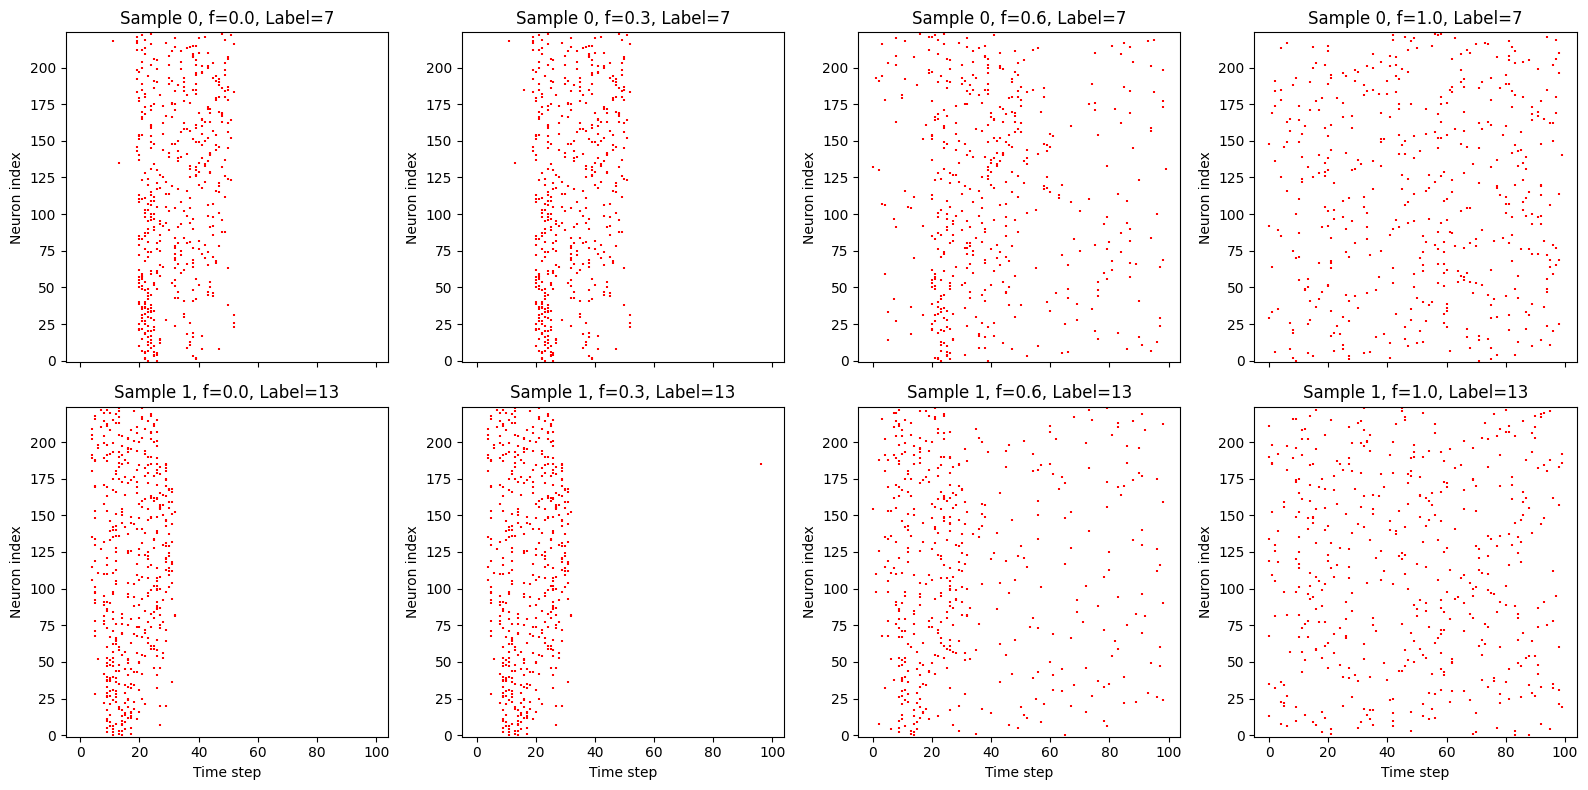

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

data = io.loadmat('shd_norm.mat')
X = data["X"]  # shape (N, 700, 100)
Y = data["Y"].flatten()  # shape (N,)

N, n_neurons, T = X.shape
print("X shape:", X.shape, "Y shape:", Y.shape)

def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=50):

    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)

    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        if len(spike_times) == 0:
            continue

        num_to_jitter = int(len(spike_times) * f)
        if num_to_jitter < 1:
            continue

        chosen_times = np.random.choice(spike_times, size=num_to_jitter, replace=False)
        new_train[neuron_idx, chosen_times] = 0

        attempts = 0
        inserted = 0
        while inserted < num_to_jitter and attempts < max_attempts * num_to_jitter:
            attempts += 1
            new_t = np.random.randint(0, T)
            if new_train[neuron_idx, new_t] == 0:
                new_train[neuron_idx, new_t] = 1
                inserted += 1

    return new_train

def data_generator_with_randomization(X, Y, batch_size=4, f=0.5, shuffle=True):
    """
    generator: generater for (x_batch, y_batch) with partial randomization
      - X.shape = (N, n_neurons, T)
      - Y.shape = (N,)
    do partial randomization when generating batches rather than all data
    """
    N = len(Y)
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)

    num_batches = N // batch_size
    for b in range(num_batches):
        batch_idx = indices[b * batch_size : (b + 1) * batch_size]

        x_batch = np.zeros((batch_size, X.shape[1], X.shape[2]), dtype=np.uint8)
        y_batch = np.zeros((batch_size,), dtype=np.int32)

        for i, idx in enumerate(batch_idx):
            x_randomized = partial_randomize_spike_train(X[idx], f=f)
            x_batch[i] = x_randomized
            y_batch[i] = Y[idx]

        yield x_batch, y_batch

print("\n--- getting a batch from generator ---")
gen = data_generator_with_randomization(X, Y, batch_size=4, f=0.3, shuffle=True)
x_batch, y_batch = next(gen)
print("x_batch:", x_batch.shape, "y_batch:", y_batch)

# 3) visualization: for the same sample, test the effect of different f
sample_indexes = [0, 1]
f_values = [0.0, 0.3, 0.6, 1.0]

fig, axes = plt.subplots(len(sample_indexes), len(f_values), figsize=(16, 8), sharex=True)
if len(sample_indexes) == 1:
    axes = [axes]

for i, sample_idx in enumerate(sample_indexes):
    label = Y[sample_idx] 
    
    for j, f_val in enumerate(f_values):
        randomized_train = partial_randomize_spike_train(X[sample_idx], f=f_val)
        
        ax = axes[i][j] if len(sample_indexes)>1 else axes[j]

        for neuron_idx in range(randomized_train.shape[0]):
            spike_times = np.where(randomized_train[neuron_idx] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                       s=2, marker='|', color='red')

        ax.set_title(f"Sample {sample_idx}, f={f_val}, Label={label}")
        ax.set_ylabel("Neuron index")
        ax.set_ylim(-1, randomized_train.shape[0])
        if i == len(sample_indexes) - 1:
            ax.set_xlabel("Time step")

plt.tight_layout()
plt.show()


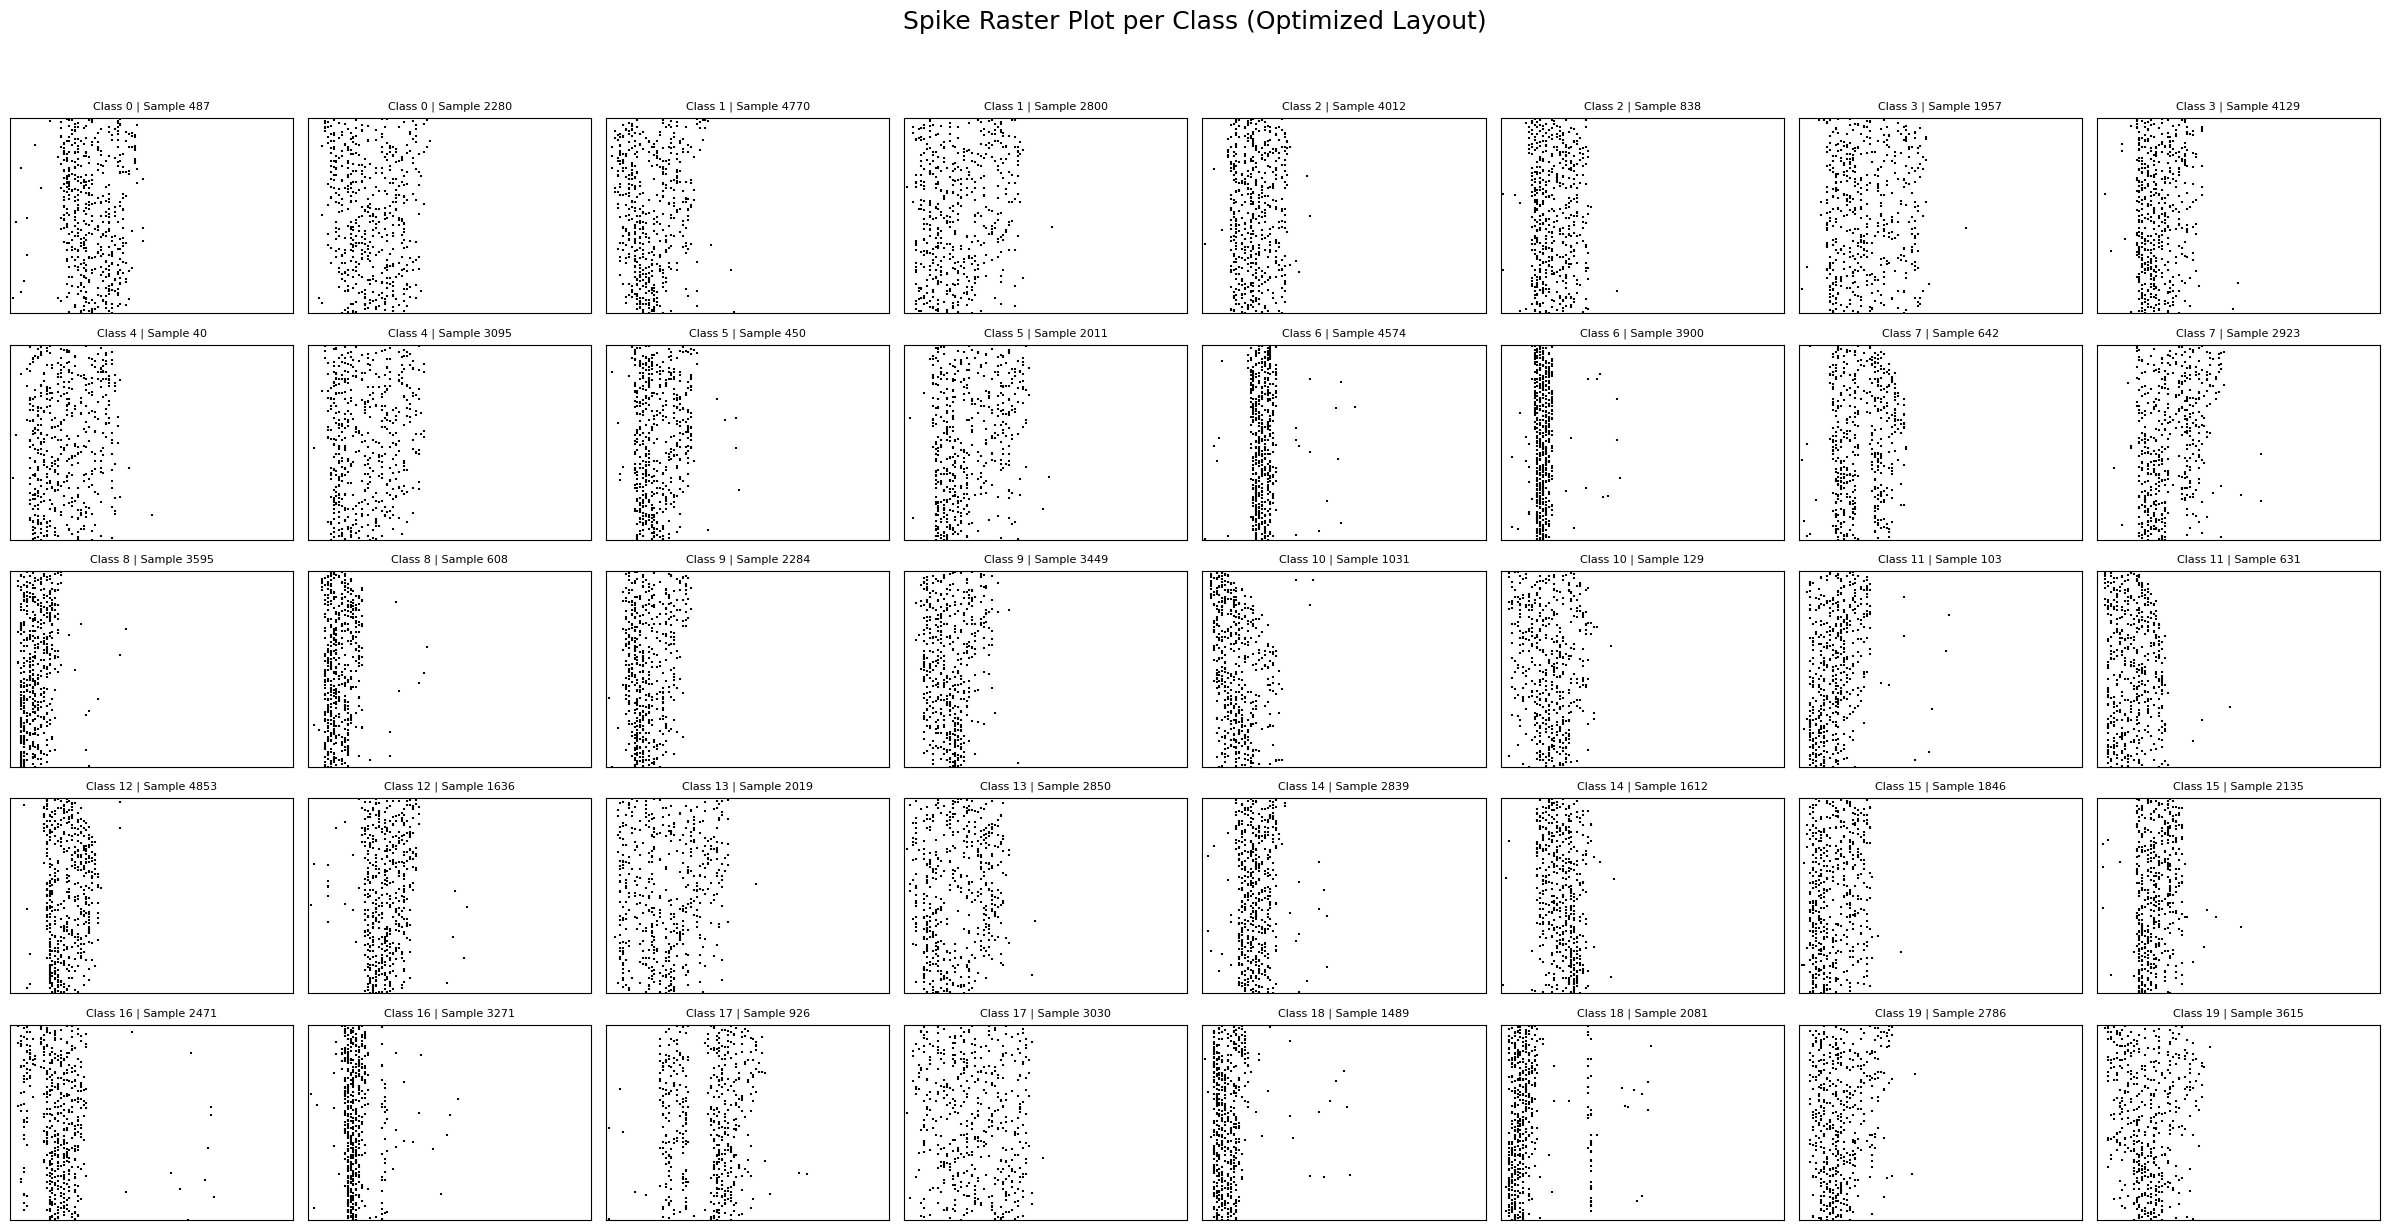

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import math

data = io.loadmat('shd_norm.mat')
X = data['X']  # shape = (N, num_neurons, T)
Y = data['Y'].ravel()

N, num_neurons, T = X.shape
unique_labels = np.unique(Y)
num_classes = len(unique_labels)

num_samples_per_class = 2
total_plots = num_classes * num_samples_per_class

ncols = 8
nrows = math.ceil(total_plots / ncols)

np.random.seed(42)
selected_samples = []
for cls in unique_labels:
    cls_indices = np.where(Y == cls)[0]
    selected = np.random.choice(cls_indices, size=num_samples_per_class, replace=False)
    selected_samples.extend([(int(cls), idx) for idx in selected])

# Visualization
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 2.5*nrows), sharex=True, sharey=True)
axes = axes.flatten()
fig.suptitle("Spike Raster Plot per Class (Optimized Layout)", fontsize=18)

for i, (cls, sample_idx) in enumerate(selected_samples):
    ax = axes[i]
    spike_mat = X[sample_idx, :, :]
    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
        ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                   s=1.5, marker='|', color='black')

    ax.set_title(f"Class {cls} | Sample {sample_idx}", fontsize=8)
    ax.set_xlim([0, T])
    ax.set_ylim([0, num_neurons])
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(len(selected_samples), len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Begin Here to Train

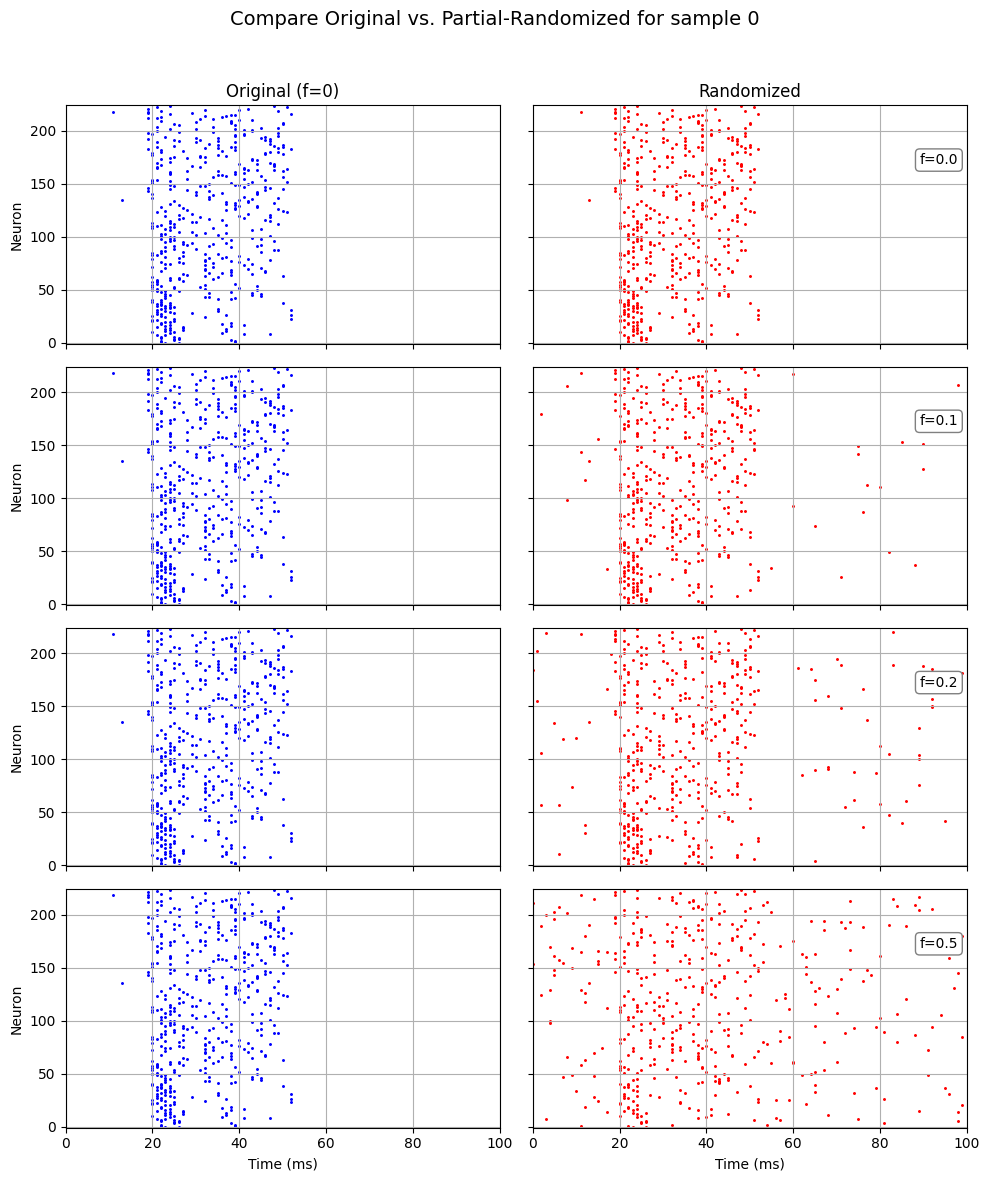

Using data index range = [0, 3276), total 3276 samples
batch_size=2
num_time_points=100
num_batches=1638
RAM usage per batch ~ 0.0003 GB
Got a batch: x_batch.shape=(2, 224, 100), y_batch=[18 17]


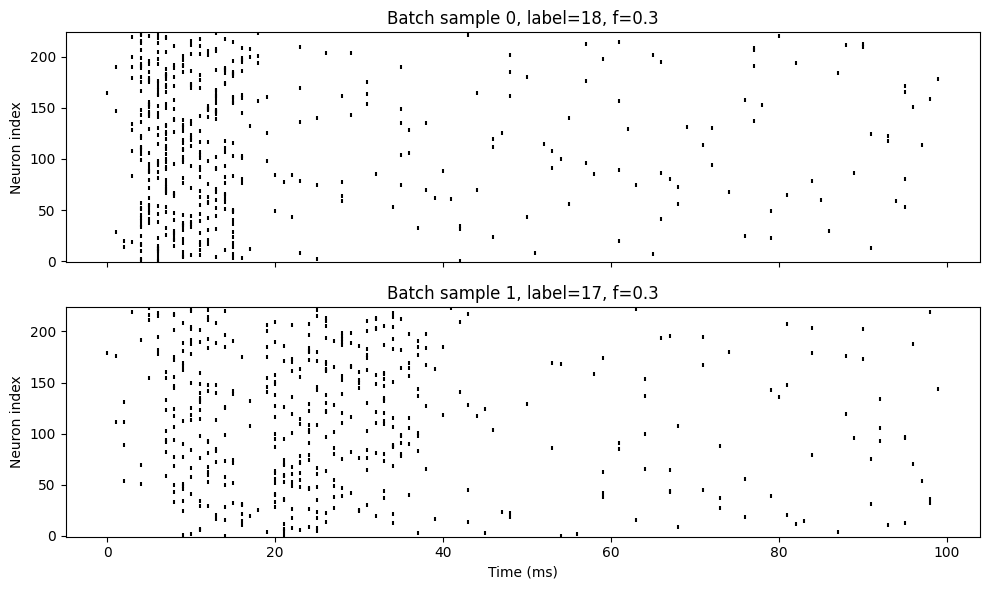

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=500):
    if f <= 0:
        return spike_train

    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)

    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        for old_time in spike_times:
            # with probability f, move this spike
            if np.random.rand() < f:
                # 1) clear the old spike position
                new_train[neuron_idx, old_time] = 0

                # 2) insert a new spike at a random time 
                inserted = False
                attempts = 0
                while not inserted and attempts < max_attempts:
                    attempts += 1
                    new_t = np.random.randint(0, T) 
                    if new_train[neuron_idx, new_t] == 0:
                        new_train[neuron_idx, new_t] = 1
                        inserted = True


    return new_train
    
def num_batches_if(time_fractions, batch_size=32, max_num_batches=None):
    """
    return how many batches can be generated in the given time_fractions
    """
    f_start, f_end = time_fractions
    N = X.shape[0]
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    sub_len = end_idx - start_idx
    n_batches = sub_len // batch_size
    if max_num_batches is not None:
        n_batches = min(n_batches, max_num_batches)
    return n_batches

def batched_data(time_fractions, X, Y, batch_size=4, f=0.5,
                 verbose=False, shuffle=True, max_num_batches=None,
                 max_attempts=50):
    """
    for (x_batch, y_batch) in batched_data(...):
        # x_batch.shape = (batch_size, n_neurons, T)
        # y_batch.shape = (batch_size,)
    """
    N = len(Y)
    f_start, f_end = time_fractions
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    subX = X[start_idx:end_idx]  # [sub_len, n_neurons, T]
    subY = Y[start_idx:end_idx]  # [sub_len]
    sub_len = len(subY)

    indices = np.arange(sub_len)
    if shuffle:
        np.random.shuffle(indices)

    num_batches = sub_len // batch_size
    if max_num_batches is not None:
        num_batches = min(num_batches, max_num_batches)

    num_neurons = X.shape[1]
    num_time_points = X.shape[2]

    if verbose:
        print(f"Using data index range = [{start_idx}, {end_idx}), total {sub_len} samples")
        print(f"{batch_size=}")
        print(f"{num_time_points=}")
        print(f"{num_batches=}")
        print(f"RAM usage per batch ~ {batch_size * num_time_points * num_neurons * 8 / (1024)**3:.4f} GB")

    for b in range(num_batches):
        batch_idx = indices[b*batch_size : (b+1)*batch_size]
        x_batch = np.zeros((batch_size, subX.shape[1], subX.shape[2]), dtype=np.uint8)
        y_batch = np.zeros((batch_size,), dtype=np.int32)
        for i, sidx in enumerate(batch_idx):
            x_random = partial_randomize_spike_train(subX[sidx], f=f, max_attempts=max_attempts)
            x_batch[i] = x_random
            y_batch[i] = subY[sidx]
        yield x_batch, y_batch

# Load SHD Dataset
from scipy.io import loadmat
data = loadmat("shd_norm.mat")
X = data["X"]
Y = data["Y"].ravel()
num_neurons = X.shape[1]
total_samples = X.shape[0]        

training_range   = (0, 0.6)   
validation_range = (0.6, 0.75)
testing_range    = (0.75, 0.9)

def show_single_sample_different_f(X, Y, sample_idx=0, f_values=[0.0, 0.3, 0.9]):
    """
    Do partial randomization for the same sample with different f values.
    """
    original_st = X[sample_idx]  # shape = (n_neurons, T)
    fig, axes = plt.subplots(len(f_values), 2, figsize=(10, 3 * len(f_values)), sharex=True, sharey=True)
    fig.suptitle(f"Compare Original vs. Partial-Randomized for sample {sample_idx}", fontsize=14)

    for row_i, f_ in enumerate(f_values):
        # Left: Original
        ax_left = axes[row_i, 0]
        for neuron_idx in range(original_st.shape[0]):
            spike_times = np.where(original_st[neuron_idx] == 1)[0]
            ax_left.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                            s=5, color='b', marker='.')
        if row_i == 0:
            ax_left.set_title("Original (f=0)")
        ax_left.set_ylabel('Neuron')
        ax_left.grid(True)

        # Right: Partial Randomized
        x_rand = partial_randomize_spike_train(original_st, f=f_)
        ax_right = axes[row_i, 1]
        for neuron_idx in range(x_rand.shape[0]):
            spike_times = np.where(x_rand[neuron_idx] == 1)[0]
            ax_right.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                             s=5, color='r', marker='.')
        if row_i == 0:
            ax_right.set_title("Randomized")
        ax_right.text(0.98, 0.8, f"f={f_:.1f}", transform=ax_right.transAxes,
                      ha='right', va='top', fontsize=10,
                      bbox=dict(boxstyle="round", fc="white", ec="gray"))
        ax_right.grid(True)

        for ax in (ax_left, ax_right):
            ax.set_ylim([-1, original_st.shape[0]])
            ax.set_xlim([0, original_st.shape[1]])

    axes[-1, 0].set_xlabel('Time (ms)')
    axes[-1, 1].set_xlabel('Time (ms)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def demo_batch_visualization(X, Y, time_fractions=(0, 0.2), batch_size=2, f=0.5):
    """
    Use batched_data() to get one batch and do visualization.
    """
    gen = batched_data(time_fractions, X, Y, batch_size=batch_size, f=f, shuffle=True, verbose=True)
    x_batch, y_batch = next(gen)
    print(f"Got a batch: x_batch.shape={x_batch.shape}, y_batch={y_batch}")

    fig, axes = plt.subplots(batch_size, 1, figsize=(10, 3*batch_size), sharex=True, sharey=True)
    if batch_size == 1:
        axes = [axes]

    for i in range(batch_size):
        ax = axes[i]
        spike_mat = x_batch[i]  # shape=(n_neurons, T)
        for neuron_idx in range(spike_mat.shape[0]):
            spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                       s=5, marker='|', color='black')
        ax.set_title(f"Batch sample {i}, label={y_batch[i]}, f={f}")
        ax.set_ylabel("Neuron index")
        ax.set_ylim([-1, spike_mat.shape[0]])
    axes[-1].set_xlabel("Time (ms)")
    plt.tight_layout()
    plt.show()


show_single_sample_different_f(X, Y, sample_idx=0, f_values=[0.0,0.1,0.2,0.5])
demo_batch_visualization(X, Y, time_fractions=training_range, batch_size=2, f=0.3)

## Build the Spiking Neural Network Model (SNN)

In [ ]:
import matplotlib.pyplot as plt

# check the effect of partial randomization on a single sample
def visualize_sample_spike_train(X, Y, index=0):
    """
    可视化单个样本的 spike train。
    参数:
        X: shape = (N, num_neurons, T)
        Y: shape = (N,)
        index: 要可视化的样本编号
        自动获取时间步长度
    """
    spike_train = X[index]  # shape: (neurons, T)
    time_window = spike_train.shape[1]

    fig, ax = plt.subplots(figsize=(12, 5))
    im = ax.imshow(spike_train[:, :time_window], aspect='auto', cmap='Greys', interpolation='nearest')
    ax.set_title(f"Spike Train Sample #{index} | Label: {Y[index]} | Time steps: {time_window}")
    ax.set_xlabel("Time step")
    ax.set_ylabel("Neuron index")
    ax.set_xlim([0, time_window])
    ax.set_ylim([0, spike_train.shape[0]])
    plt.colorbar(im, ax=ax, label="Spike")
    plt.tight_layout()
    plt.show()


Padded X from 100 to 200 time steps.
X shape after padding: (5460, 224, 200)


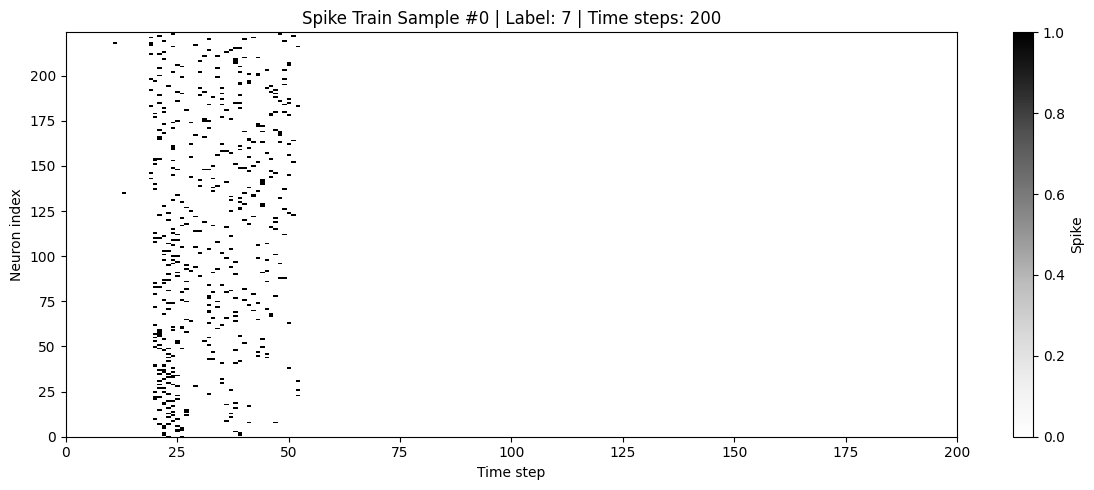

In [ ]:
import os, numpy as np, torch, torch.nn as nn, slayerSNN as snn
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import loadmat

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load and pad data ===
data = loadmat("shd_norm.mat")
X = data["X"]  # shape: (samples, neurons, 100)
Y = data["Y"].ravel()
num_neurons, T = X.shape[1], X.shape[2]
num_classes = len(np.unique(Y))
T_ori = T
# Pad some space for delay
T_target = 200
if T < T_target:
    padded = np.zeros((X.shape[0], num_neurons, T_target), dtype=X.dtype)
    padded[:, :, :T] = X
    X = padded
    T = T_target
    print(f"Padded X from {T_ori} to {T_target} time steps.")
    
print(f"X shape after padding: {X.shape}")  # e.g. (9984, 700, 400)

visualize_sample_spike_train(X, Y, index=0)

# === SNN parameters ===
sim_param = dict(Ts=1, tSample=200)
lif_param = dict(type='SRMALPHA', theta=10, tauSr=1, tauRho=0.1, tauRef=2, scaleRef=2, scaleRho=0.1)

training_range   = (0.0, 0.6)
validation_range = (0.6, 0.75)
testing_range    = (0.75, 0.9)

def preprocess_full_dataset(X, Y, f, batch_size=128, seed=42):
    np.random.seed(seed)

    # === Get deterministic training indices ===
    N = len(Y)
    train_start, train_end = training_range
    val_start, val_end = validation_range
    test_start, test_end = testing_range

    train_indices = np.arange(int(N * train_start), int(N * train_end))
    val_indices   = np.arange(int(N * val_start), int(N * val_end))
    test_indices  = np.arange(int(N * test_start), int(N * test_end))

    np.random.shuffle(train_indices)

    def process_indices(indices):
        X_out = np.array([partial_randomize_spike_train(X[i], f) for i in indices])
        Y_out = Y[indices]
        return X_out, Y_out

    X_train, Y_train = process_indices(train_indices)
    X_val, Y_val     = process_indices(val_indices)
    X_test, Y_test   = process_indices(test_indices)

    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)


def partial_randomize_spike_train(spike_train, f=0.0, max_attempts=50):
    if f <= 0:
        return spike_train

    num_neurons, T = spike_train.shape
    new_train = np.copy(spike_train)

    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        for old_time in spike_times:
            # with probability f, move this spike
            if np.random.rand() < f:
                # 1) clear the old spike position
                new_train[neuron_idx, old_time] = 0
                # 2) insert a new spike at a random time 
                inserted = False
                attempts = 0
                while not inserted and attempts < max_attempts:
                    attempts += 1
                    new_t = np.random.randint(0, T) 
                    if new_train[neuron_idx, new_t] == 0:
                        new_train[neuron_idx, new_t] = 1
                        inserted = True
    return new_train

def num_batches_if(time_fractions, batch_size=64, max_num_batches=None):
    f_start, f_end = time_fractions
    N = X.shape[0]
    sub_len = int(N * (f_end - f_start))
    n_batches = sub_len // batch_size
    return min(n_batches, max_num_batches) if max_num_batches else n_batches

def batched_data(time_fractions, X, Y, batch_size=128, f=0.0, shuffle=True, max_num_batches=None):
    N = len(Y)
    f_start, f_end = time_fractions
    indices = np.arange(int(N * f_start), int(N * f_end))
    if shuffle: np.random.shuffle(indices)
    n_batches = int(np.ceil(len(indices) / batch_size))
    if max_num_batches: n_batches = min(n_batches, max_num_batches)

    for b in range(n_batches):
        start = b * batch_size
        end = min((b + 1) * batch_size, len(indices))
        batch_idx = indices[start:end]
        xb = np.array([partial_randomize_spike_train(X[i], f) for i in batch_idx])
        yb = Y[batch_idx]
        yield xb, yb


# === Network ===
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        slayer = snn.layer(lif_param, sim_param)
        self.slayer = slayer
        self.fc1 = nn.utils.weight_norm(slayer.dense(224, 128), name='weight')
        self.fc2 = nn.utils.weight_norm(slayer.dense(128, 128), name='weight')
        self.fc3 = nn.utils.weight_norm(slayer.dense(128, 20), name='weight')
        self.delay1 = slayer.delay(128)
        self.delay2 = slayer.delay(128)

    def forward(self, x):
        if isinstance(x, np.ndarray): x = torch.from_numpy(x)
        if x.dim() == 3: x = x.unsqueeze(2).unsqueeze(3)
        x = x.float().to(device)
        x = self.slayer.spike(self.fc1(self.slayer.psp(x)))
        x = self.delay1(x)
        x = self.slayer.spike(self.fc2(self.slayer.psp(x)))
        x = self.delay2(x)
        x = self.slayer.spike(self.fc3(self.slayer.psp(x)))
        return x

    def clamp(self, thea1, thea2):
        self.delay1.delay.data.clamp_(0, thea1)
        self.delay2.delay.data.clamp_(0, thea2)

# === Accuracy ===
def test_accuracy(net, time_range, batch_size=64, f=0.0):
    net.eval(); correct = total = 0
    with torch.no_grad():
        for xb, yb in batched_data(time_range, X, Y, batch_size=batch_size, f=f, shuffle=False):
            x = torch.tensor(xb).unsqueeze(2).unsqueeze(3).float().to(device)
            pred = snn.predict.getClass(net(x))
            correct += (pred.cpu().numpy() == yb).sum()
            total += len(yb)
    return correct / total

# === Train ===
def train_model(X_train, Y_train, X_val, Y_val, f=0.0, epochs=100, bs=128, lr=0.1, seed=42):
    from slayerSNN import spikeLoss, utils
    import random
    import torch.backends.cudnn as cudnn

    def set_seed(seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            cudnn.benchmark = False
            cudnn.deterministic = True
            cudnn.enabled = False

    set_seed(seed)
    net = Network().to(device)

    error_cfg = {
        'neuron': lif_param,
        'simulation': sim_param,
        'training': {
            'error': {
                'type': 'SpikeRate',
                'tgtSpikeRegion': {'start': 0, 'stop': 200},
                'tgtSpikeRate': {True: 0.2, False: 0.02}
            }
        }
    }
    loss_fn = spikeLoss.spikeLoss(error_cfg).to(device)
    optimizer = utils.optim.Nadam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300], gamma=0.1)

    best_val = float('inf')
    best_state = None
    loss_log, val_log = [], []
    update1 = update2 = 0
    thea1 = thea2 = 64
    early_stop_counter = 0
    early_stop_patience = 300

    from math import ceil
    
    total_steps = epochs * ceil(len(X_train) / bs)
    with tqdm(total=total_steps) as pbar:
        for epoch in range(epochs):
            net.train()
            batch_losses = []

            indices = np.arange(len(Y_train))
            np.random.shuffle(indices)
            for b in range(0, len(indices), bs):
                batch_idx = indices[b:b+bs]
                xb = X_train[batch_idx]
                yb = Y_train[batch_idx]

                x = torch.tensor(xb).unsqueeze(2).unsqueeze(3).float().to(device)
                y = torch.tensor(yb).long().to(device)
                target = torch.zeros((len(y), num_classes, 1, 1, 1), device=device)
                target.scatter_(1, y[:, None, None, None, None], 1.0)

                out = net(x)
                loss = loss_fn.spikeRate(out, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                batch_losses.append(loss.item())
                pbar.update(1)

            # Clamp delay
            if epoch <= 250:
                net.clamp(64, 64)
            else:
                update1 += 1; update2 += 1
                for name, param in net.named_parameters():
                    if "delay1.delay" in name and update1 > 150:
                        sorted_ = torch.sort(torch.floor(param.detach().flatten()))[0]
                        thea1 = torch.max(sorted_)
                        if sorted_[108] > (thea1 - 5):
                            thea1 += 1
                            update1 = 0
                            print(f"Updated delay1 to {thea1}")
                    elif "delay2.delay" in name and update2 > 150:
                        sorted_ = torch.sort(torch.floor(param.detach().flatten()))[0]
                        thea2 = torch.max(sorted_)
                        if sorted_[108] > (thea2 - 5):
                            thea2 += 1
                            update2 = 0
                            print(f"Updated delay2 to {thea2}")
                net.clamp(thea1, thea2)

            net.eval(); val_loss = 0; correct = total = 0
            with torch.no_grad():
                for b in range(0, len(Y_val), bs):
                    xb = X_val[b:b+bs]
                    yb = Y_val[b:b+bs]
                    x = torch.tensor(xb).unsqueeze(2).unsqueeze(3).float().to(device)
                    y = torch.tensor(yb).long().to(device)
                    target = torch.zeros((len(y), num_classes, 1, 1, 1), device=device)
                    target.scatter_(1, y[:, None, None, None, None], 1.0)
                    out = net(x)
                    val_loss += loss_fn.spikeRate(out, target).item()
                    pred = snn.predict.getClass(out)
                    correct += (pred.cpu() == y.cpu()).sum().item()
                    total += len(y)

            val_loss /= max(1, len(Y_val) // bs)
            val_acc = correct / total
            loss_log.append(np.mean(batch_losses))
            val_log.append(val_loss)

            if val_loss < best_val:
                best_val = val_loss
                best_state = net.state_dict()
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= early_stop_patience:
                    print(f"Early stopped at epoch {epoch+1} (val_loss={val_loss:.4f})")
                    break

            pbar.set_postfix_str(
                f"Ep {epoch+1} | Train {loss_log[-1]:.3f} | Val {val_loss:.3f} | Val Acc {val_acc:.2%}"
            )
            scheduler.step()

    if best_state: net.load_state_dict(best_state)
    plt.figure()
    plt.semilogy(loss_log, label='Train Loss')
    plt.semilogy(val_log, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title("Train vs. Val Loss"); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()
    return net

def test_accuracy_cached(net, X_test, Y_test, batch_size=64):
    net.eval(); correct = total = 0
    with torch.no_grad():
        for b in range(0, len(Y_test), batch_size):
            xb = X_test[b:b+batch_size]
            yb = Y_test[b:b+batch_size]
            x = torch.tensor(xb).unsqueeze(2).unsqueeze(3).float().to(device)
            pred = snn.predict.getClass(net(x))
            correct += (pred.cpu().numpy() == yb).sum()
            total += len(yb)
    return correct / total

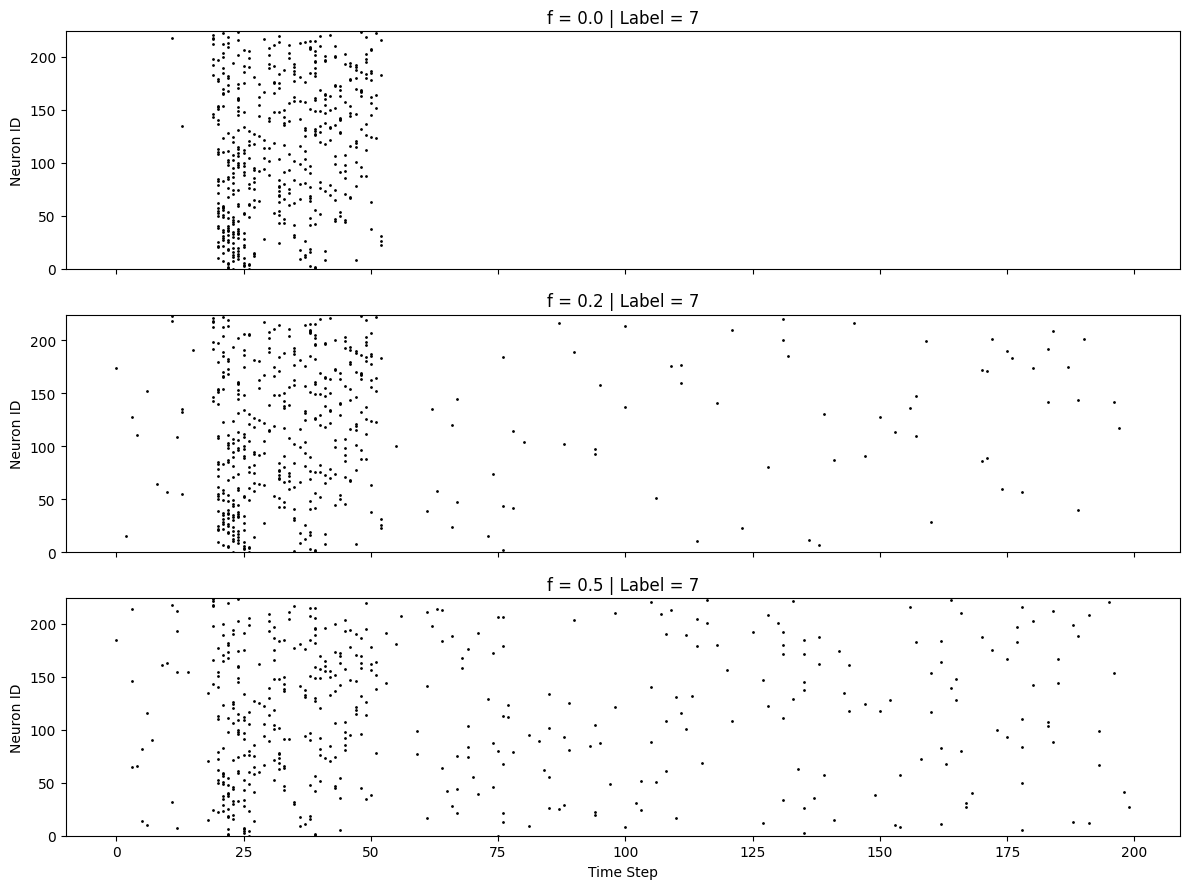

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_batched_sample_from_f(f_values, time_fractions=(0.0, 0.6), batch_size=64, index_in_batch=0):
    """
    visualize the spike trains of the first sample in each batch
    """
    num_plots = len(f_values)
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 3 * num_plots), sharex=True)

    if num_plots == 1:
        axes = [axes]

    for ax, f in zip(axes, f_values):
        # 使用 batched_data 获取一个 batch
        data_gen = batched_data(time_fractions, X, Y, batch_size=batch_size, f=f, shuffle=False, max_num_batches=1)
        xb, yb = next(data_gen)
        sample = xb[index_in_batch]
        label = yb[index_in_batch]

        for neuron_idx in range(sample.shape[0]):
            spike_times = np.where(sample[neuron_idx] == 1)[0]
            ax.scatter(spike_times, np.ones_like(spike_times) * neuron_idx, s=1, color='black')

        ax.set_title(f"f = {f} | Label = {label}")
        ax.set_ylabel("Neuron ID")
        ax.set_ylim([0, sample.shape[0]])

    axes[-1].set_xlabel("Time Step")
    plt.tight_layout()
    plt.show()

visualize_batched_sample_from_f(f_values=[0.0, 0.2, 0.5], time_fractions=(0.0, 0.6), batch_size=64, index_in_batch=0)



Preprocessing for f = 0


/root/miniconda3/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training for f = 0


 40%|████      | 10451/26000 [19:04<25:18, 10.24it/s, Ep 401 | Train 290.950 | Val 336.491 | Val Acc 46.64%] 

Updated delay1 to 65.0
Updated delay2 to 65.0


 55%|█████▌    | 14377/26000 [26:16<19:32,  9.91it/s, Ep 552 | Train 282.338 | Val 335.127 | Val Acc 47.74%]

Updated delay1 to 66.0
Updated delay2 to 66.0


 70%|███████   | 18303/26000 [33:26<12:49, 10.00it/s, Ep 703 | Train 278.725 | Val 332.632 | Val Acc 47.86%]

Updated delay1 to 67.0
Updated delay2 to 67.0


 85%|████████▌ | 22229/26000 [40:33<05:38, 11.14it/s, Ep 854 | Train 274.197 | Val 331.289 | Val Acc 47.86%]

Updated delay1 to 68.0
Updated delay2 to 68.0


100%|██████████| 26000/26000 [47:27<00:00,  9.13it/s, Ep 1000 | Train 268.621 | Val 328.057 | Val Acc 49.94%]


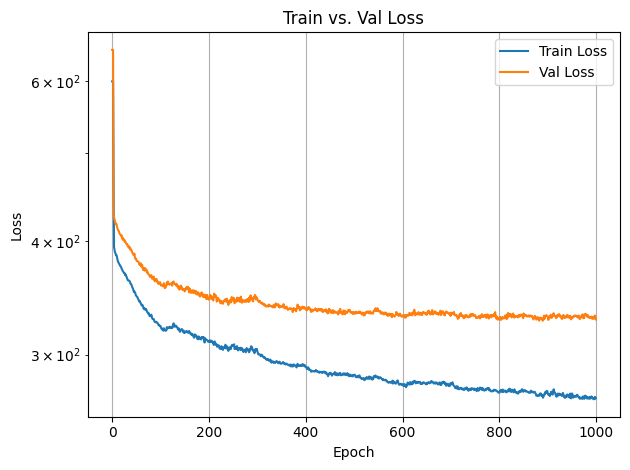

Saved shdelay_norm_f00.pt | Test Accuracy: 47.74%

Preprocessing for f = 0.1
Training for f = 0.1


 40%|████      | 10451/26000 [18:06<26:53,  9.64it/s, Ep 401 | Train 311.488 | Val 353.203 | Val Acc 40.42%] 

Updated delay1 to 65.0
Updated delay2 to 65.0


 55%|█████▌    | 14377/26000 [25:24<21:48,  8.89it/s, Ep 552 | Train 303.984 | Val 349.388 | Val Acc 41.76%]

Updated delay1 to 66.0
Updated delay2 to 66.0


 70%|███████   | 18303/26000 [32:44<15:40,  8.19it/s, Ep 703 | Train 299.222 | Val 346.563 | Val Acc 44.32%]

Updated delay1 to 67.0
Updated delay2 to 67.0


 86%|████████▌ | 22230/26000 [40:01<05:52, 10.70it/s, Ep 854 | Train 292.615 | Val 344.590 | Val Acc 43.10%]

Updated delay1 to 68.0
Updated delay2 to 68.0


100%|██████████| 26000/26000 [47:00<00:00,  9.22it/s, Ep 1000 | Train 291.525 | Val 344.435 | Val Acc 45.54%]


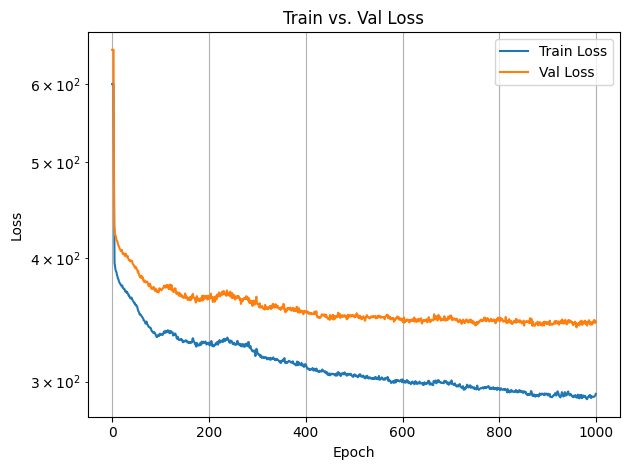

Saved shdelay_norm_f01.pt | Test Accuracy: 42.98%

Preprocessing for f = 0.2
Training for f = 0.2


 40%|████      | 10452/26000 [19:09<28:14,  9.17it/s, Ep 401 | Train 322.453 | Val 365.300 | Val Acc 34.92%] 

Updated delay1 to 65.0
Updated delay2 to 65.0


 55%|█████▌    | 14378/26000 [26:21<19:04, 10.15it/s, Ep 552 | Train 314.028 | Val 358.894 | Val Acc 37.48%]

Updated delay1 to 66.0
Updated delay2 to 66.0


 70%|███████   | 18303/26000 [33:36<12:54,  9.94it/s, Ep 703 | Train 307.573 | Val 356.564 | Val Acc 37.97%]

Updated delay1 to 67.0
Updated delay2 to 67.0


 86%|████████▌ | 22230/26000 [40:47<06:07, 10.26it/s, Ep 854 | Train 297.874 | Val 352.649 | Val Acc 39.32%]

Updated delay1 to 68.0
Updated delay2 to 68.0


100%|██████████| 26000/26000 [47:46<00:00,  9.07it/s, Ep 1000 | Train 292.876 | Val 354.127 | Val Acc 40.42%]


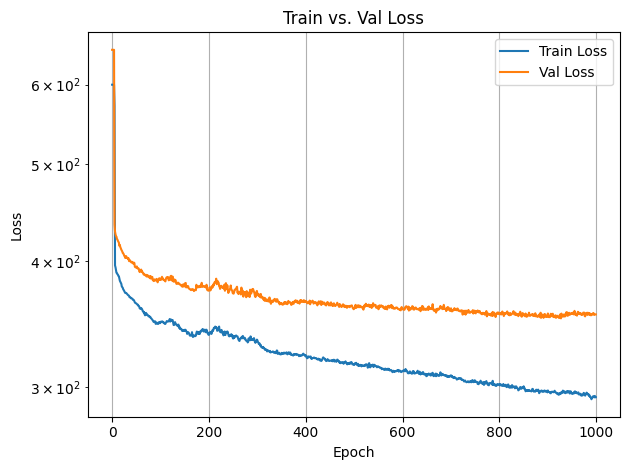

Saved shdelay_norm_f02.pt | Test Accuracy: 41.39%

Preprocessing for f = 0.3
Training for f = 0.3


 40%|████      | 10451/26000 [18:07<25:28, 10.17it/s, Ep 401 | Train 325.659 | Val 370.183 | Val Acc 32.60%] 

Updated delay1 to 65.0
Updated delay2 to 65.0


 55%|█████▌    | 14377/26000 [24:39<12:46, 15.16it/s, Ep 552 | Train 316.633 | Val 367.050 | Val Acc 36.51%]

Updated delay1 to 66.0
Updated delay2 to 66.0


 70%|███████   | 18304/26000 [30:53<11:17, 11.35it/s, Ep 703 | Train 309.968 | Val 363.501 | Val Acc 36.75%]

Updated delay1 to 67.0
Updated delay2 to 67.0


 85%|████████▌ | 22229/26000 [38:04<07:14,  8.68it/s, Ep 854 | Train 302.183 | Val 363.063 | Val Acc 37.97%]

Updated delay1 to 68.0
Updated delay2 to 68.0


100%|██████████| 26000/26000 [44:51<00:00,  9.66it/s, Ep 1000 | Train 298.178 | Val 360.998 | Val Acc 37.73%]


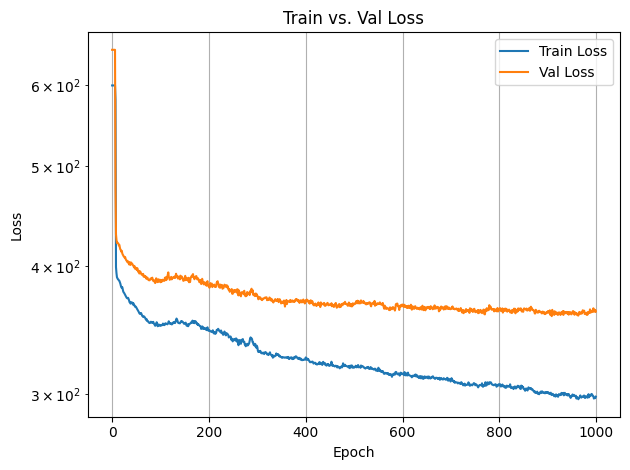

Saved shdelay_norm_f03.pt | Test Accuracy: 43.35%

Preprocessing for f = 0.4
Training for f = 0.4


 40%|████      | 10451/26000 [18:42<23:44, 10.91it/s, Ep 401 | Train 334.546 | Val 376.499 | Val Acc 29.67%] 

Updated delay1 to 65.0
Updated delay2 to 65.0


 55%|█████▌    | 14378/26000 [25:45<17:35, 11.01it/s, Ep 552 | Train 326.153 | Val 370.377 | Val Acc 32.11%]

Updated delay1 to 66.0
Updated delay2 to 66.0


 70%|███████   | 18303/26000 [32:52<10:37, 12.07it/s, Ep 703 | Train 317.810 | Val 367.240 | Val Acc 33.21%]

Updated delay1 to 67.0
Updated delay2 to 67.0


 85%|████████▌ | 22229/26000 [39:58<06:40,  9.42it/s, Ep 854 | Train 312.696 | Val 364.786 | Val Acc 34.55%]

Updated delay1 to 68.0
Updated delay2 to 68.0


100%|██████████| 26000/26000 [46:46<00:00,  9.26it/s, Ep 1000 | Train 306.311 | Val 362.618 | Val Acc 35.65%]


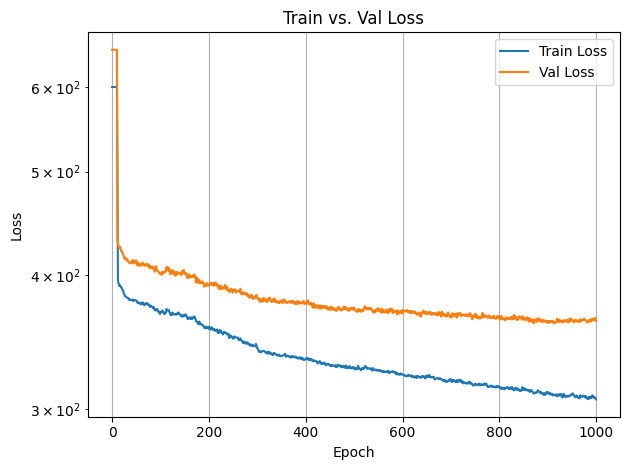

Saved shdelay_norm_f04.pt | Test Accuracy: 39.19%

Preprocessing for f = 0.5
Training for f = 0.5


 40%|████      | 10452/26000 [18:06<25:17, 10.25it/s, Ep 401 | Train 336.548 | Val 378.285 | Val Acc 25.64%] 

Updated delay1 to 65.0
Updated delay2 to 65.0


 55%|█████▌    | 14377/26000 [25:13<19:09, 10.11it/s, Ep 552 | Train 329.955 | Val 377.575 | Val Acc 26.13%]

Updated delay1 to 66.0
Updated delay2 to 66.0


 70%|███████   | 18303/26000 [32:24<12:41, 10.11it/s, Ep 703 | Train 324.957 | Val 374.451 | Val Acc 29.06%]

Updated delay1 to 67.0
Updated delay2 to 67.0


 86%|████████▌ | 22230/26000 [39:39<06:48,  9.22it/s, Ep 854 | Train 318.817 | Val 375.338 | Val Acc 28.57%]

Updated delay1 to 68.0
Updated delay2 to 68.0


100%|██████████| 26000/26000 [45:01<00:00,  9.62it/s, Ep 1000 | Train 313.847 | Val 372.375 | Val Acc 31.99%]


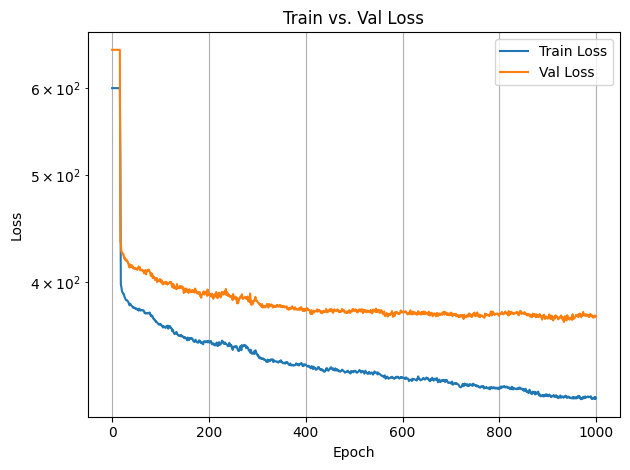

Saved shdelay_norm_f05.pt | Test Accuracy: 32.36%

Preprocessing for f = 0.6
Training for f = 0.6


 40%|████      | 10451/26000 [19:01<25:38, 10.11it/s, Ep 401 | Train 333.760 | Val 382.498 | Val Acc 28.94%] 

Updated delay1 to 65.0
Updated delay2 to 65.0


 55%|█████▌    | 14377/26000 [26:12<19:29,  9.94it/s, Ep 552 | Train 327.662 | Val 382.714 | Val Acc 26.98%]

Updated delay1 to 66.0
Updated delay2 to 66.0


 70%|███████   | 18303/26000 [33:25<12:50,  9.99it/s, Ep 703 | Train 325.872 | Val 386.258 | Val Acc 25.40%]

Updated delay1 to 67.0
Updated delay2 to 67.0


 73%|███████▎  | 19032/26000 [34:45<12:43,  9.13it/s, Ep 731 | Train 319.963 | Val 383.742 | Val Acc 28.08%]

Early stopped at epoch 732 (val_loss=382.0400)


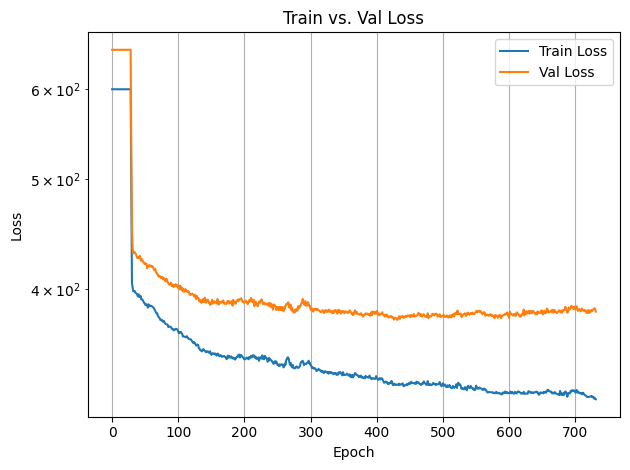

Saved shdelay_norm_f06.pt | Test Accuracy: 28.94%

Preprocessing for f = 0.7
Training for f = 0.7


 40%|████      | 10451/26000 [17:56<25:33, 10.14it/s, Ep 401 | Train 357.086 | Val 398.559 | Val Acc 18.80%] 

Updated delay2 to 65.0


 55%|█████▌    | 14378/26000 [25:02<19:01, 10.19it/s, Ep 552 | Train 350.337 | Val 393.985 | Val Acc 21.98%]

Updated delay2 to 66.0


 70%|███████   | 18303/26000 [32:09<12:30, 10.25it/s, Ep 703 | Train 344.100 | Val 395.045 | Val Acc 19.90%]

Updated delay2 to 67.0


 85%|████████▌ | 22229/26000 [39:16<06:30,  9.66it/s, Ep 854 | Train 336.986 | Val 394.424 | Val Acc 19.54%]

Updated delay2 to 68.0


100%|██████████| 26000/26000 [46:04<00:00,  9.40it/s, Ep 1000 | Train 334.046 | Val 393.787 | Val Acc 21.61%]


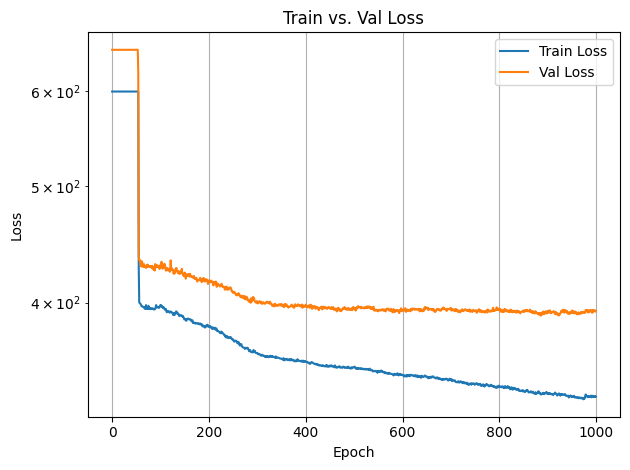

Saved shdelay_norm_f07.pt | Test Accuracy: 21.61%

Preprocessing for f = 0.8
Training for f = 0.8


 40%|████      | 10451/26000 [18:44<25:41, 10.08it/s, Ep 401 | Train 353.642 | Val 412.359 | Val Acc 12.09%] 

Updated delay2 to 65.0


 55%|█████▌    | 14377/26000 [25:48<18:47, 10.31it/s, Ep 552 | Train 349.220 | Val 413.505 | Val Acc 11.72%]

Updated delay2 to 66.0


 57%|█████▋    | 14794/26000 [26:34<20:07,  9.28it/s, Ep 568 | Train 347.365 | Val 412.553 | Val Acc 13.43%]

Early stopped at epoch 569 (val_loss=412.5763)


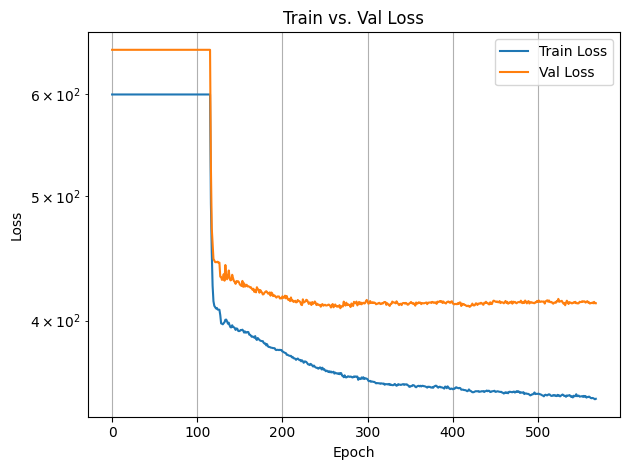

Saved shdelay_norm_f08.pt | Test Accuracy: 13.06%

Preprocessing for f = 0.9
Training for f = 0.9


 60%|█████▉    | 15574/26000 [26:12<17:32,  9.90it/s, Ep 598 | Train 366.315 | Val 433.537 | Val Acc 8.30%] 

Early stopped at epoch 599 (val_loss=434.7109)


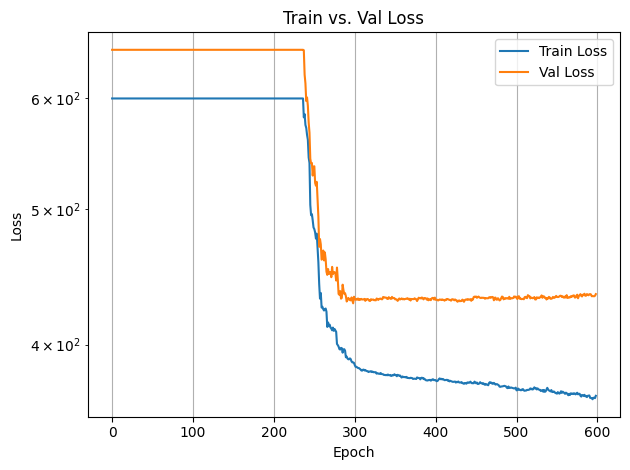

Saved shdelay_norm_f09.pt | Test Accuracy: 7.33%

Preprocessing for f = 1.0
Training for f = 1.0


 30%|███       | 7826/26000 [13:01<30:14, 10.02it/s, Ep 300 | Train 599.760 | Val 649.740 | Val Acc 5.49%]  

Early stopped at epoch 301 (val_loss=649.7400)


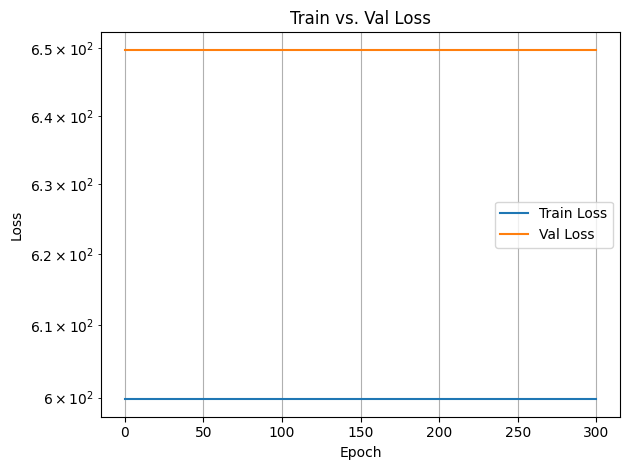

Saved shdelay_norm_f10.pt | Test Accuracy: 4.40%


In [8]:
f_values = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for f in f_values:
    print(f"\nPreprocessing for f = {f}")
    (X_train_f, Y_train_f), (X_val_f, Y_val_f), (X_test_f, Y_test_f) = preprocess_full_dataset(X, Y, f)

    print(f"Training for f = {f}")
    net = train_model(X_train_f, Y_train_f, X_val_f, Y_val_f, f=f, epochs=1000)

    model_path = f"shdelay_norm_f{int(f*10):02d}.pt"
    torch.save(net.state_dict(), model_path)

    acc = test_accuracy_cached(net, X_test_f, Y_test_f)
    print(f"Saved {model_path} | Test Accuracy: {acc:.2%}")

## Evaluation

Using device: cuda

=== Loading model shdelay_norm_f00.pt and testing (f=0.0) ===
f=0.0 | Mean Acc: 47.74% | Std: 0.00% over 5 runs

=== Loading model shdelay_norm_f01.pt and testing (f=0.1) ===
f=0.1 | Mean Acc: 45.13% | Std: 1.70% over 5 runs

=== Loading model shdelay_norm_f02.pt and testing (f=0.2) ===
f=0.2 | Mean Acc: 42.49% | Std: 0.85% over 5 runs

=== Loading model shdelay_norm_f03.pt and testing (f=0.3) ===
f=0.3 | Mean Acc: 40.02% | Std: 0.68% over 5 runs

=== Loading model shdelay_norm_f04.pt and testing (f=0.4) ===
f=0.4 | Mean Acc: 36.46% | Std: 0.92% over 5 runs

=== Loading model shdelay_norm_f05.pt and testing (f=0.5) ===
f=0.5 | Mean Acc: 33.53% | Std: 1.68% over 5 runs

=== Loading model shdelay_norm_f06.pt and testing (f=0.6) ===
f=0.6 | Mean Acc: 28.35% | Std: 0.52% over 5 runs

=== Loading model shdelay_norm_f07.pt and testing (f=0.7) ===
f=0.7 | Mean Acc: 20.71% | Std: 0.55% over 5 runs

=== Loading model shdelay_norm_f08.pt and testing (f=0.8) ===
f=0.8 | Mean A

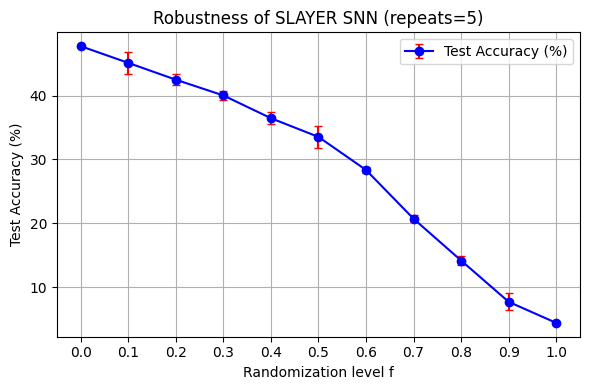

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# === Settings ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
f_values = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]  # Randomization levels
repeats = 5
print(f"Using device: {device}")

# === Dataset Split ===
testing_range = (0.75, 0.9)

# === Repeated test wrapper ===
def test_accuracy_repeats(net, repeats=5, f=0.0):
    acc_list = []
    for _ in range(repeats):
        acc = test_accuracy(
            net,
            time_range=testing_range,
            batch_size=256,
            f=f
        )
        acc_list.append(acc)
    return acc_list

# === Results Container ===
all_means = []
all_stds = []

# === Loop over f-values ===
for f in f_values:
    model_path = f"shdelay_norm_f{int(f * 10):02d}.pt"
    print(f"\n=== Loading model {model_path} and testing (f={f:.1f}) ===")

    net = Network().to(device)
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.eval()

    acc_list = test_accuracy_repeats(net, repeats=repeats, f=f)
    mean_acc = np.mean(acc_list)
    std_acc = np.std(acc_list)

    all_means.append(mean_acc)
    all_stds.append(std_acc)

    print(f"f={f:.1f} | Mean Acc: {mean_acc:.2%} | Std: {std_acc:.2%} over {repeats} runs")

# === Plot ===
plt.figure(figsize=(6, 4))
means_pct = [m * 100 for m in all_means]
stds_pct  = [s * 100 for s in all_stds]

plt.errorbar(f_values, means_pct, yerr=stds_pct,
             fmt='-o', color='blue', ecolor='red', capsize=3,
             label='Test Accuracy (%)')

plt.xlabel("Randomization level f")
plt.ylabel("Test Accuracy (%)")
plt.title(f"Robustness of SLAYER SNN (repeats={repeats})")
plt.grid(True)
plt.xticks(f_values)
plt.legend()
plt.tight_layout()
plt.show()
